# Fail Segmenter

In [1]:
from PIL import Image

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import argparse

sys.path.append(os.getcwd()[:-len("/Additional")])
import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools

from tflite_support.metadata_writers import image_segmenter
from tflite_support.metadata_writers import writer_utils


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

np.set_printoptions(threshold=sys.maxsize)
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.config.run_functions_eagerly(False)

In [8]:
# Generall Parameters
MODEL= 'Fail'
DATA = 'SceneNetFloorTiledTextureRandom'
TRAIN_DS ='Train'
TEST_DS = 'Test'
HALF = False

# Dataset Loading Parameters
#IMG_SIZE_HEIGHT = 1280
#IMG_SIZE_WIDTH = 720
IMG_SIZE = (1280, 720)
IMG_SIZE_MODEL = (640, 360)
NUM_CLASSES = 3
MAX_IMG_TRAIN = 500
MAX_IMG_TEST = 300
SEED = None
BATCH_SIZE = 1
CACHE = True

# Model Parameters
SAVE = True

## Data preprocessing

In [9]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, make_dirs=True)

train_ds, img_count_train = data_processing.load_dataset(paths,"TRAIN", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF, MAX_IMG_TRAIN)
train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, 
                                              img_count=img_count_train)

test_ds, img_count_test = data_processing.load_dataset(paths,"TEST", IMG_SIZE, IMG_SIZE_MODEL, NUM_CLASSES, HALF,
                                                       MAX_IMG_TEST, noise_std=None)

test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, 
                                             img_count=img_count_test)


(None, None, 1)
The TRAIN Dataset contains 500 images.
(None, None, 1)
The TEST Dataset contains 300 images.


2022-07-26 14:24:53.013561: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


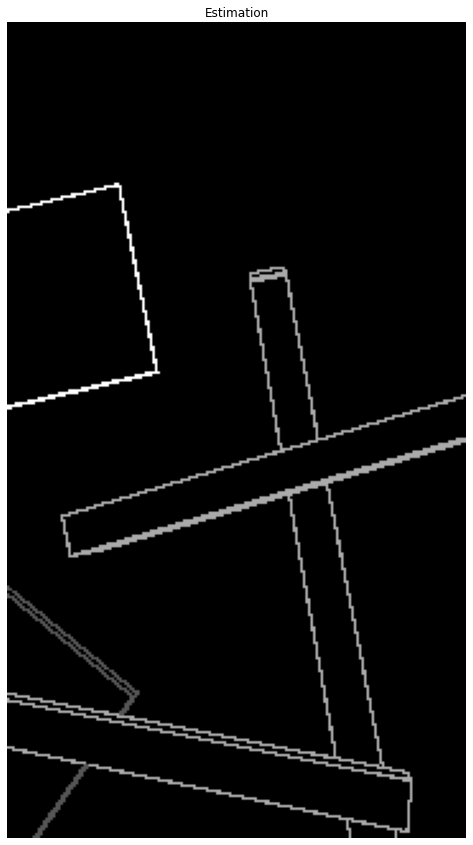

(1, 320, 180, 1)


In [10]:
for img, label in test_ds.take(1):
    img, label = img, label

#label = tf.cast(label, tf.uint8)
plt.figure(figsize=[10,15])
#plt.subplot(1,2,1)
#plt.title("Images")
#plt.imshow(img[0,:,:,:])
#plt.axis('off')
#plt.subplot(1,2,2)
plt.title("Estimation")
plt.imshow(label[0,:,:,0], cmap="gray", vmin = 0, vmax = 3)
plt.axis('off')
plt.show()

print(label.shape)

2022-07-26 14:24:53.831369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


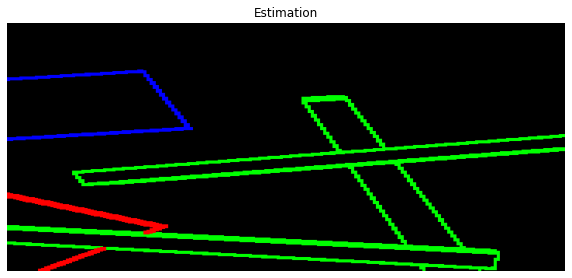

(1, 320, 720, 3)


In [11]:
for img, label in test_ds.take(1):
    img, label = img, label

new_shape_label = (320,720)
new_shape_img = (1280,720)
# label 3D
label = tf.cast(label, tf.int32)
class_range = tf.range(1, NUM_CLASSES + 1)
class_range_reshape = tf.reshape(class_range, [1, 1, 1, NUM_CLASSES])
label_re = tf.cast(class_range_reshape == label, dtype=tf.int32)
pad = tf.constant([[0,0],[0,0],[0,0],[1,0]])
label_re = tf.pad(label_re,pad,"CONSTANT")

edge_width_height = int(IMG_SIZE[0]/new_shape_label[0])
edge_width_width = int(IMG_SIZE[1]/new_shape_label[1])
kernel = tf.ones([edge_width_height, edge_width_width, NUM_CLASSES+1, 1],tf.float32)
label_re = tf.cast(label_re, tf.float32)
label_re = tf.nn.depthwise_conv2d(label_re, kernel, strides=[1, 1, 1, 1], padding="SAME")
label_re = tf.cast(tf.clip_by_value(label_re, 0, 1), tf.int32)

label_re = tf.image.resize(label_re, new_shape_label,method='nearest', antialias=True)
label_re = tf.math.argmax(label_re,axis = -1, output_type = tf.int32)
label = tf.expand_dims(label_re,axis = -1)

# visualization
num_classes = 3
class_range = tf.range(1, num_classes+1)
class_range_reshape = tf.reshape(class_range, [1, 1, 1, 3])
class_range_reshape = tf.cast(class_range_reshape, tf.uint8)
label = tf.cast(label, tf.uint8)
label = tf.cast(class_range_reshape == label, dtype=tf.int32) * 255




#label = tf.cast(label, tf.uint8)
plt.figure(figsize=[10,15])
#plt.subplot(1,2,1)
#plt.title("Images")
#plt.imshow(img[0,:,:,:])
#plt.axis('off')
#plt.subplot(1,2,2)
plt.title("Estimation")
plt.imshow(label[0,:,:,:])
plt.axis('off')
plt.show()

print(label.shape)

# Model

In [13]:
IMG_SHAPE = [IMG_SIZE_MODEL[0],IMG_SIZE_MODEL[1],3]

inputs = tf.keras.Input(shape=IMG_SHAPE,dtype = tf.float32)
x = tf.where(inputs[:,:,:,0] >= 127, 2.0, 0.0)
x = tf.expand_dims(x,-1)
x = tf.cast(x, tf.float32)

x = tf.image.resize(x,(630,350))
x = tf.image.resize(x,(640,360))

range_reshape = tf.reshape(tf.range(1, 4), [1, 1, 1, 3])
range_reshape = tf.cast(range_reshape, dtype=tf.float32)
x = tf.cast(range_reshape == x, tf.float32)

pad = tf.constant([[0,0],[0,0],[0,0],[0,1]])
x = tf.pad(x,pad,"CONSTANT")
    
model = tf.keras.Model(inputs,x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 360, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 640, 360)         0         
 licingOpLambda)                                                 
                                                                 
 tf.math.greater_equal (TFOp  (None, 640, 360)         0         
 Lambda)                                                         
                                                                 
 tf.where (TFOpLambda)       (None, 640, 360)          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 640, 360, 1)      0         
                                                                 
 tf.cast (TFOpLambda)        (None, 640, 360, 1)       0     

2022-07-26 14:26:28.280142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


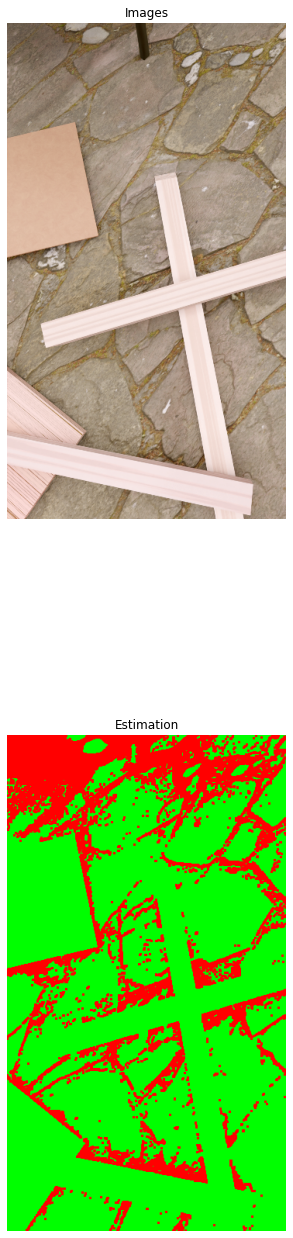

In [14]:
for img, label in test_ds.take(1):
    img, label = img, label
    
predictions = model.predict(img)
predictions = tools.predict_class_postprocessing(predictions, threshold=0.5)
visualize.plot_images(images=img, predictions=predictions, batch_size=1)




# Spezial: Full Model wurde geladen und danach darauf 2 output dim gebildet und neu abgespeichert

In [15]:
def representative_data_gen():
    for input_value in train_ds.take(100):
        img, mask = input_value
        yield [img]



model.save(paths["MODEL"])

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(paths["MODEL"])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model,gpu_compatibility=True)


# Save the model.
with open(files['OUTPUT_TFLITE_MODEL'], 'wb') as f:
    f.write(tflite_model)

    
    
# Make sure the ids match with the ones used in training.
labels = [{'name': 'background','id': 1},{'name': 'c','id': 2},{'name': 'cd','id': 3}]


# Ensure that labels list is sorted.

sorted_labels = sorted(labels, key=lambda d: d['id'])

with open(files['OUTPUT_TFLITE_LABEL_MAP'], 'w') as f:
    for label in sorted_labels:
        name = label['name']
        f.write(name + '\n')
        

ImageSegmenterWriter = image_segmenter.MetadataWriter
_MODEL_PATH = files['OUTPUT_TFLITE_MODEL']
# Task Library expects label files that are in the same format as the one below.

_SAVE_TO_PATH = files['OUTPUT_TFLITE_MODEL_METADATA']
# Normalization parameters is required when preprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0
_INPUT_NORM_STD = 1

_LABEL_FILE = files['OUTPUT_TFLITE_LABEL_MAP']

writer = ImageSegmenterWriter.create_for_inference(writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],[_LABEL_FILE])


# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)



INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/Fail/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the STRIDED_SLICE op takes
tensor #0 and tensor #9 and tensor #8 and tensor #7 as input and produces tensor #12 as output.

Subgraph#0 main(T#0) -> [T#20]
  Op#0 STRIDED_SLICE(T#0, T#9, T#8, T#7) -> [T#12]
GPU COMPATIBILITY WARNING: Slice does not support shrink_axis_mask parameter. 
  Op#1 GREATER_EQUAL(T#12, T#3) -> [T#13]
  Op#2 SELECT_V2(T#13, T#1, T#2) -> [T#14]
GPU COMPATIBILITY WARNING: Not supported op SELECT_V2
  Op#3 EXPAND_DIMS(T#14, T#6) -> [T#15]
GPU COMPATIBILITY WARNING: Not supported op EXPAND_DIMS
  Op#4 RESIZE_BILINEAR(T#15, T#5) -> [T#16]
  Op#5 RESIZE_BILINEAR(T#16, T#4) -> [T#17]
  Op#6 EQUAL(T#17, T#10) -> [T#18]
  Op#7 CAST(T#18) -> [T#19]
  Op#8 PAD(T#19, T#11) -> [T#20]

GPU COMPATIBILI

2022-07-26 14:26:35.156671: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-26 14:26:35.295172: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-26 14:26:35.295189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-26 14:26:35.295729: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/Fail
2022-07-26 14:26:35.296128: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-26 14:26:35.296138: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/Fail
2022-07-26 14:26:35.297285: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bun

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2022-07-26 14:27:06.195175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 295 of 500


(1, 640, 360, 4)
(640, 360)


2022-07-26 14:27:13.513922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


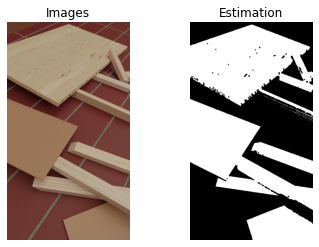

In [16]:
import numpy as np

# Load the model.
interpreter = tf.lite.Interpreter(model_path=files['OUTPUT_TFLITE_MODEL_METADATA'])

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]

from PIL import Image
from PIL import ImageOps

for img, label in train_ds.take(1):
    img, label = img, label
    
img = tf.cast(img, tf.float32)
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()

raw_prediction_fail = interpreter.tensor(interpreter.get_output_details()[0]['index'])()

print(raw_prediction_fail.shape)
seg_map = np.squeeze(np.argmax(raw_prediction_fail, axis=3)).astype(np.int8)


print(seg_map.shape)

# for visualization
img = img/255.0
#show image:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Images")
plt.imshow(img[0,:,:,:])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Estimation")
plt.imshow(seg_map,cmap='gray',vmin = 0,vmax = 1)
plt.axis('off')

plt.show()

# here only two layer, so choose which one you want to display using the index below: 1:2 or 0:1
